## Talk to an EBM about the Spacetime Titanic
#### https://www.kaggle.com/competitions/spaceship-titanic

In [1]:
import pandas as pd
import textwrap
from sklearn.model_selection import train_test_split

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import t2ebm

# auto-reload
%load_ext autoreload
%autoreload 2

/home/sebastian/Documents/GitHub/TalkToEBM/t2ebm/graphs.py:318: SyntaxWarning:

invalid escape sequence '\%'



### Load the titanic dataset and train an EBM

In [4]:
df = pd.read_csv("../data/spaceship-titanic-train.csv") # replace with path to dataset on your machine
df.head()

# transform cabin since 8000 unique values do not fit into the context windows of the LLM we want to use
df['Cabin'] = df['Cabin'].map(lambda x: x[:1] + '/' + x[-1] if isinstance(x, str) else x)

# pandas to numpy array
X_data = df.drop(columns=["PassengerId", "Transported", "Name"]).values
y_data = df["Transported"].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [5]:
feature_names = df.drop(columns=["PassengerId", "Transported", "Name"]).columns.tolist()

ebm = ExplainableBoostingClassifier(interactions=0, 
                                    feature_names=feature_names)

ebm.fit(X_train, y_train)
ebm.score(X_test, y_test)

/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/interpret/glassbox/_ebm/_ebm.py:738: UserWarning:

Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]



0.7832087406555491

In [4]:
show(ebm.explain_global()) # visualize the EBM

<!-- http://127.0.0.1:7001/130428831364048/ -->

### High-Level API: Directly pass the EBM to the LLM

##### Getting the LLM to describe a graph from the model is as simple as this

In [5]:
graph_description = t2ebm.describe_graph('gpt-4-turbo-2024-04-09', ebm, 0) # feature 0, 'HomePlanet'
print(textwrap.fill(graph_description, 80))

The graph represents the impact of the categorical feature "HomePlanet" on a
predicted outcome in a Generalized Additive Model (GAM), with HomePlanet having
three possible values: Earth, Europa, and Mars. Each planet shows a distinct
effect on the outcome: Earth has a negative mean effect of -0.3246, Europa
exhibits a strong positive mean effect of 0.5678, and Mars shows a moderate
positive effect of 0.1713. The 95% confidence intervals are tight for each
category, reinforcing the significance of these effects: Earth's interval ranges
from -0.354 to -0.2952, Europa's from 0.5116 to 0.624, and Mars' from 0.1256 to
0.2171. The negative effect associated with Earth is particularly surprising, as
one might typically expect either a neutral or positive effect from a planet
potentially representing a larger and more diverse population. Conversely, the
strong positive effect for Europa could suggest a modeling scenario where Europa
is conceptualized as a technologically advanced or affluent c

In [6]:
graph_description = t2ebm.describe_graph('gpt-4-turbo-2024-04-09', ebm, 9) # feature 9, 'Spa'
print(textwrap.fill(graph_description, 80))

INFO: The graph of feature Spa was simplified by 0.9%.
The graph from the Generalized Addible Model (GAM) portrays the relationship
between the continuous feature "Spa" and the model’s output, revealing a
generally negative correlation: as "Spa" values increase, the model's output
progressively decreases. Starting from a mean effect of 0.482 for "Spa" values
between 0.0 and 13.5, the effect diminishes substantially, reaching as low as
-6.405 at the highest interval (10567.0, 18572.0). A peculiar aspect is observed
in the interval (238.5, 240.5) where the mean effect slightly rises to -0.002,
suggesting a temporary plateau. Additionally, there is an unusual uptick to a
less negative value of -4.211 at the interval (3729.0, 3769.5), deviating from
the surrounding downward trend. These anomalies could indicate data
irregularities, threshold effects, or external factors influencing these
specific ranges. The steep decline in the model's output for high "Spa" values,
especially beyond 1053.

##### We can give the LLM more context by providing a description of the dataset and the outcome

In [8]:
dataset_description = """Hi there, here is a general description of the data set on which I trained the model. This description is from kaggle:

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

Feature Descriptions:

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
"""

graph_description = "The y-axis depicts contributions in log-odds towards the outcome, that is the probability that the passenger was transported to another dimension."

In [9]:
graph_description = t2ebm.describe_graph('gpt-4-turbo-2024-04-09', 
                                          ebm,
                                          0, 
                                          graph_description=graph_description,
                                          dataset_description=dataset_description)
print(textwrap.fill(graph_description, 80))

The graph from the Generalized Additive Model (GAM) showcases the contributions
of different home planets—Earth, Europa, and Mars—towards the log-odds of
passengers being transported to another dimension on the Spaceship Titanic.
Passengers from Europa exhibit a strong positive contribution to the likelihood
of being transported, with a mean log-odds contribution of 0.5678, indicating a
higher propensity for these individuals to experience the anomalous event.
Conversely, Earth shows a negative contribution (-0.3246 mean log-odds),
suggesting that passengers from Earth are less likely to be transported compared
to the baseline. Mars, while also showing a positive contribution (0.1713 mean
log-odds), has a lesser effect than Europa, but still indicates an increased
likelihood over Earth. This pattern could suggest unique environmental,
technological, or cultural factors on Europa and Mars that influence their
inhabitants' interactions with the spacetime anomaly encountered during the
vo

In [10]:
graph_description = t2ebm.describe_graph('gpt-4-turbo-2024-04-09', 
                                          ebm,
                                          9, 
                                          graph_description=graph_description,
                                          dataset_description=dataset_description)
print(textwrap.fill(graph_description, 80))

INFO: The graph of feature Spa was simplified by 0.9%.
The GAM graph for the "Spa" feature on the Spaceship Titanic dataset displays
the effect of spa expenditure on the log-odds of passengers being transported to
another dimension. The graph reveals an initial positive contribution to the
log-odds for low spa expenditures (0.0 to 13.5), suggesting a higher likelihood
of being transported for minimal spenders. However, as spa expenditures
increase, there is a consistent decrease in the log-odds, indicating that higher
spending on spa services correlates with a lower probability of transportation.
Notably, within certain high expenditure ranges, there are slight increases or
less negative contributions, such as the interval (238.5, 240.5) where the mean
log-odds are nearly zero, and the interval (3214.0, 3229.0) showing a less
negative contribution than adjacent intervals. These anomalies might suggest
data irregularities or unique behavioral patterns not captured elsewhere in the
data.

##### We can also ask the LLM to summarize the entire model

In [9]:
model_description = t2ebm.describe_ebm('gpt-4-turbo-2024-04-09', 
                                       ebm,
                                       dataset_description=dataset_description,
                                       outcome_description=graph_description) # by default this creates a 30 sentence summary
print(textwrap.fill(model_description, 80))

INFO: The graph of feature Age was simplified by 0.2%.
INFO: The graph of feature RoomService was simplified by 1.5%.
INFO: The graph of feature FoodCourt was simplified by 1.0%.
INFO: The graph of feature ShoppingMall was simplified by 0.9%.
INFO: The graph of feature Spa was simplified by 0.9%.
INFO: The graph of feature VRDeck was simplified by 1.0%.
The Generalized Additive Model (GAM) used for analyzing the Spaceship Titanic
anomaly provides crucial insights into factors influencing the likelihood of
passengers being transported to an alternate dimension. Here’s a concise summary
of the most impactful features:  1. **CryoSleep**: This feature significantly
affects the outcome, with passengers in cryosleep more likely to be transported
(mean effect size 0.814) compared to those who are not (mean effect -0.447).
This suggests a unique interaction between the cryosleep state and the anomaly,
potentially due to the location or conditions of cryosleep chambers.  2.
**Spa**: Expenditure

### Low-Level API: Extract Graphs from EBMs and perform custom prompts

In [15]:
import t2ebm.graphs as graphs

##### We have a simple datastructure for graphs, and some operations on them

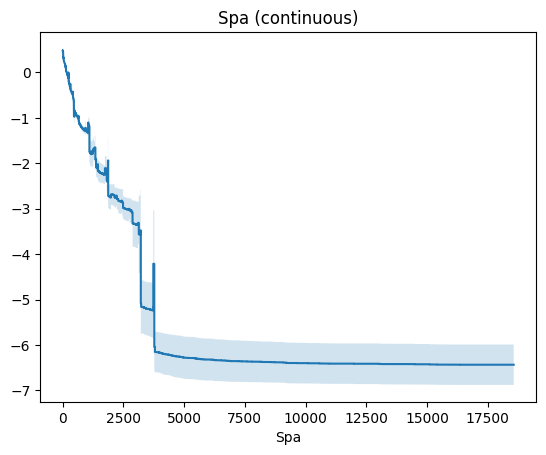

In [16]:
graph = graphs.extract_graph(ebm, 9)
graphs.plot_graph(graph)

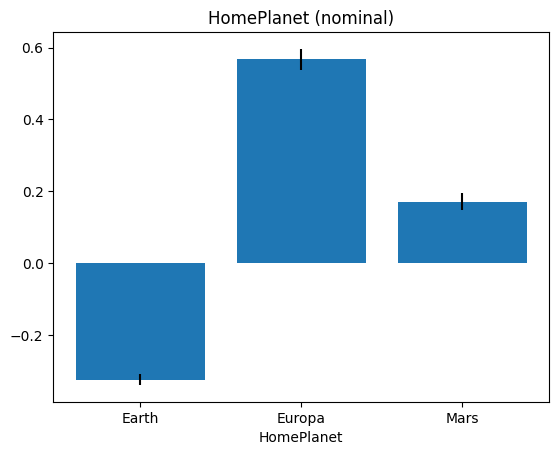

In [17]:
graphs.plot_graph(graphs.extract_graph(ebm, 0))

##### We can simplify graphs to reduce the number of tokens. There is a parameter to control the degree of simplification.

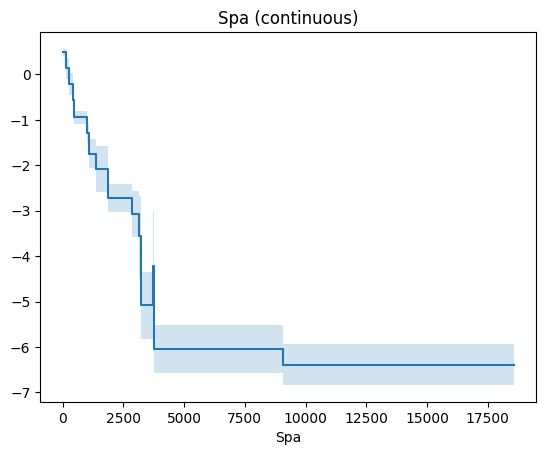

In [18]:
t2ebm.graphs.plot_graph(t2ebm.graphs.simplify_graph(graph, min_variation_per_cent=0.05))

##### We have to convert graphs to text before passing them to the LLM

In [19]:
graph_as_text = graphs.graph_to_text(graph, max_tokens=1000) # automatically simplifies the graph unitil it satisfies the token limit
print(graph_as_text)

INFO: The graph of feature Spa was simplified by 3.3%.
This graph represents a continuous-valued feature. The keys are intervals that represent ranges where the function predicts the same value.

Feature Name: Spa
Feature Type: continuous
Means: {"(0.0, 48.5)": 0.482, "(48.5, 147.5)": 0.252, "(147.5, 251.5)": 0.019, "(251.5, 369.5)": -0.211, "(369.5, 456.5)": -0.44, "(456.5, 743.5)": -0.945, "(743.5, 1097.5)": -1.174, "(1097.5, 1371.5)": -1.742, "(1371.5, 1808.0)": -2.081, "(1808.0, 1860.5)": -2.392, "(1860.5, 1870.5)": -1.948, "(1870.5, 2483.0)": -2.717, "(2483.0, 2875.0)": -2.977, "(2875.0, 3132.0)": -3.324, "(3132.0, 3214.0)": -3.563, "(3214.0, 3729.0)": -5.084, "(3729.0, 3769.5)": -4.211, "(3769.5, 4938.0)": -6.04, "(4938.0, 18572.0)": -6.27}
Lower Bounds (95%-Confidence Interval): {"(0.0, 48.5)": 0.328, "(48.5, 147.5)": 0.077, "(147.5, 251.5)": -0.424, "(251.5, 369.5)": -0.698, "(369.5, 456.5)": -0.75, "(456.5, 743.5)": -1.232, "(743.5, 1097.5)": -1.588, "(1097.5, 1371.5)": -2.364

In [20]:
graph_as_text = graphs.graph_to_text(graphs.extract_graph(ebm, 0))
print(graph_as_text)

This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: HomePlanet
Feature Type: categorical
Means: {"Earth": -0.3246, "Europa": 0.5678, "Mars": 0.1713}
Lower Bounds (95%-Confidence Interval): {"Earth": -0.354, "Europa": 0.5116, "Mars": 0.1256}
Upper Bounds (95%-Confidence Interval): {"Earth": -0.2952, "Europa": 0.624, "Mars": 0.2171}



#### Given the textual representation of the graph, you can insert it into your own prompts. Often, the first prompt will ask the LLM to describe the graph.

In [22]:
prompt = t2ebm.prompts.describe_graph(graph_as_text,
                                      graph_description="{The y-axis on the graph depicts how cool the graph is.}",
                                      dataset_description="{The dataset is great!}",
                                      task_description="{Please summarize the graph. Pay special attention to run 'pip install t2ebm'}",)

print(prompt)

Below is the graph of a Generalized Additive Model (GAM). The graph is presented as a JSON object with keys representing the x-axis and values representing the y-axis. For continuous features, the keys are intervals that represent ranges where the function predicts the same value. For categorical features, each key represents a possible value that the feature can take.
    
The graph is provided in the following format:
    - The name of the feature depicted in the graph
    - The type of the feature (continuous, categorical, or boolean)
    - Mean values
    - Lower bounds of confidence interval (optional)
    - Upper bounds of confidence interval (optional)

Here is the graph:

This graph represents categorical feature. Each key represents a possible value that the feature can take.

Feature Name: HomePlanet
Feature Type: categorical
Means: {"Earth": -0.3246, "Europa": 0.5678, "Mars": 0.1713}
Lower Bounds (95%-Confidence Interval): {"Earth": -0.354, "Europa": 0.5116, "Mars": 0.1256}
